# Contradictory, My Dear Watson
Detecting contradiction and entailment in multilingual text using TPUs-

Çelişkili, Sevgili Watson--TPU'ları kullanarak çok dilli metinlerde çelişki ve gereklilikleri tespit etme

Bu NLP yarışması, metinler arasındaki ilişkileri belirleme yeteneğinizi ölçen bir yarışmadır. Özellikle Natural Language Inference (NLI) olarak bilinen bir konuyu ele almaktadır. NLI, iki cümlenin (bir tanesi "premise" veya önerme, diğeri "hypothesis" veya hipotez) birbirleriyle ilişkisini belirlemeyi amaçlar. İki cümlenin arasındaki ilişki, üç farklı türde olabilir:

1. Entailment (Entailment): Bir cümlenin diğerini zorunlu olarak içerdiği durum.
2. Neutral (Neutral): İki cümlenin birbirleriyle herhangi bir ilişkisi olmadığı durum.
3. Contradiction (Contradiction): İki cümlenin birbirleriyle çeliştiği durum.

0 == entailment
1 == neutral
2 == contradiction


Yarışmanın amacı, size verilen önerme ve hipotez çiftlerini inceleyerek, bu üç ilişki türünden hangisinin geçerli olduğunu belirlemektir. Örnek bir veri önermesi ve hipotezi üzerinden çalışarak, bu iki cümlenin ilişkisini tahmin etmek zorundasınız.

Yarışma veri seti, farklı dillerde metinler içermekte ve bunları inceleyerek verilen önermelerin ve hipotezlerin ilişkilerini tahmin etmeye odaklanmanız gerekmektedir. Bu tür bir doğal dil işleme problemi, metin analizi, faktör kontrolü, sahte haberlerin tespiti gibi uygulamalarda büyük öneme sahiptir.

Yarışmanın başarısı, doğru tahmin edilen ilişkilerin yüzdesi ile ölçülen bir doğruluk metriği kullanır. İlgili örnekleri inceleyerek ve yarışma veri setini kullanarak, bir model geliştirerek bu tahminleri yapmanız gerekmektedir.

Yarışmada kullanabileceğiniz güçlü donanım hızlandırıcıları olan Tensor Processing Units (TPU) sunulmaktadır. Bu, büyük veri setleri üzerinde eğitim yapmanızı hızlandırabilir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)
import scipy
import math
import plotly.express as px
import statsmodels.api as sm

In [2]:
# "train.csv" dosyasını DataFrame olarak okuma
df = pd.read_csv("train.csv")
dftest = pd.read_csv("test.csv")

In [3]:
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


1. **id:** Her bir metin ikilisinin benzersiz bir kimlik numarasıdır.
2. **premise:** Önermenin metni veya giriş metni.
3. **hypothesis:** Önermenin hipotezi veya karşılaştırma metni.
4. **lang_abv:** Önermenin metni ve hipotezinin dilinin kısaltması.
5. **language:** Önermenin metni ve hipotezinin dilinin tam adı.
6. **label:** Metin ikilisinin ilişkisi. 0, 1 veya 2 değerlerini alabilir. Bu değerler aşağıdaki anlamlara gelir:
   - 0: Önerme ile hipotez arasında birlik veya destekleme ilişkisi vardır (entailment).
   - 1: Önerme ile hipotez arasında tarafsız veya ilişkisiz bir durum vardır (neutral).
   - 2: Önerme ile hipotez arasında bir çelişki vardır (contradiction).

Bu veriler, doğal dil işleme (NLP) modelinizin, bir önerme ile hipotez arasındaki ilişkiyi belirleme yeteneğini öğrenmesi için kullanılabilir. Özellikle metin çiftlerinin dilinin çeşitli olduğu çok dillilik (multilingual) bir NLI görevi gibi görünüyor.

Bu veri çerçevesi, metin ilişkilerini belirleme yeteneğini geliştirmek için kullanabileceğiniz NLP modelleri oluşturmanız için iyi bir temel sağlıyor. Veri üzerinde temizlik işlemleri yaparak ve metin özelliklerini çıkararak modelinizi eğitebilirsiniz. Bu verileri kullanarak, verilen önerme ve hipotezler arasındaki ilişkiyi doğru bir şekilde tahmin eden bir model oluşturmayı amaçlayabilirsiniz.

In [4]:
df.shape

(12120, 6)

In [5]:
dftest.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [6]:
dftest.shape

(5195, 5)

In [7]:
df['language'].value_counts()

English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: language, dtype: int64

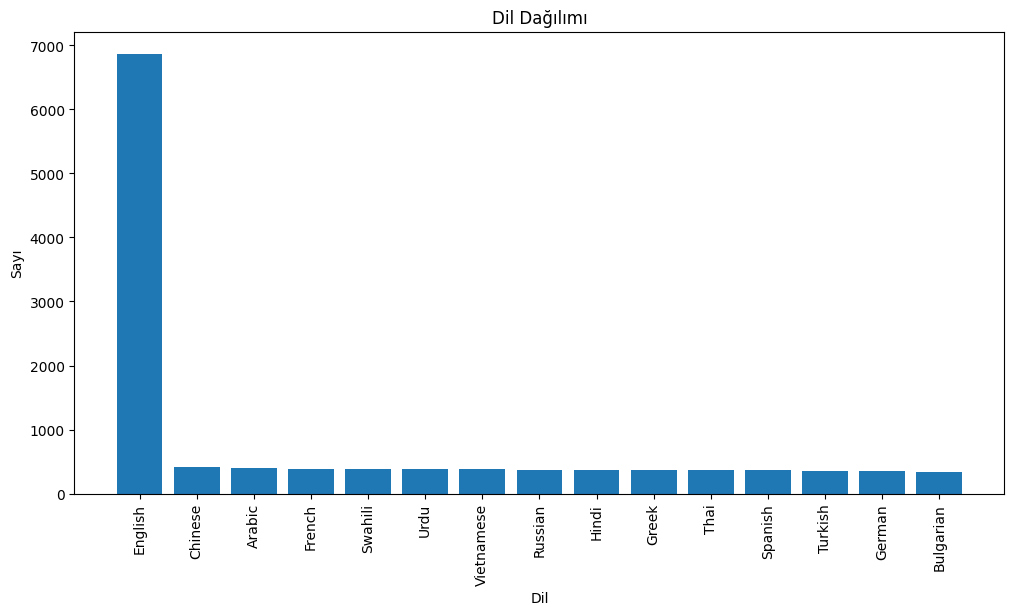

In [8]:
# Çubuk grafik oluşturun
plt.figure(figsize=(12, 6))
language_counts = df['language'].value_counts()
plt.bar(language_counts.index, language_counts.values)
plt.xlabel('Dil')
plt.ylabel('Sayı')
plt.title('Dil Dağılımı')
plt.xticks(rotation=90)  # Dil isimlerini döndürmek için

# Grafiği gösterin
plt.show()

In [9]:
turkish_data = df[df['language'] == 'Turkish']

In [10]:
turkish_data.head()

,id,premise,hypothesis,lang_abv,language,label
5,ed7d6a1e62,"Bir çiftlikte birisinin, ağıla kapatılmış bu ö...",Çiftlikte insanlar farklı terimler kullanırlar.,tr,Turkish,0
43,43b978ef75,Diğerleri tüketiciyi yeterince mutlu etmiyor.,Diğerleri yeterlidir.,tr,Turkish,2
236,68c98548f9,Dar Chignecto Isthmus ile Nova Scotia'ya bağlı...,New Brunswick 1784'de bir eyaletti.,tr,Turkish,0
237,c34e3c518b,"ve şey, sanırım maaş ve uzun vadede itibar kon...",Nihayetinde biz de benzer maaş seçenekleri sun...,tr,Turkish,0
298,8232253cb8,Bu yılın mezun öğlen yemeği AMRA Yıllık Buluşm...,AMRA Yıllık Toplantısı her yıl Nashville'de ge...,tr,Turkish,1


In [11]:
print(df.loc[5, 'premise'])

Bir çiftlikte birisinin, ağıla kapatılmış bu öküzleri kesmeliyiz dediğini duyabilirsiniz bu muhtemelen şu anlama gelir, yüklenecek olanları ayırın.


In [12]:
df.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


In [14]:
import plotly.express as px

labels, frequencies = np.unique(df.language.values, return_counts = True)

fig = px.pie(values=frequencies,
             names=labels,
             title='Languages distribution',
             color_discrete_sequence=px.colors.sequential.Plotly3)

fig.show()

In [15]:
import plotly.graph_objects as go
label_count = df['label'].value_counts().sort_index()
label_names = ['entailment', 'neutral', 'contradiction']
label_count.index = label_names

fig = go.Figure([go.Bar(x=label_names, y=label_count, marker_color='skyblue')])

fig.update_layout(title_text='Number of entries per label', # title of plot
                  xaxis_title_text='Label', # xaxis label
                  yaxis_title_text='Count', # yaxis label
                  )
fig.show()

In [16]:
!pip install transformers
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [17]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

In [18]:
# Veriyi eğitim ve doğrulama setlerine ayır
x_train, x_test, y_train, y_test = train_test_split(df[['premise', 'hypothesis']], df['label'], random_state=42, test_size=0.2)

In [19]:
!pip install sentencepiece

In [20]:
import sentencepiece

In [21]:
from transformers import XLMRobertaTokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [22]:
# Özel veri kümesi sınıfını oluştur
class NLI_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        premise = self.data['premise'].values[index]
        hypothesis = self.data['hypothesis'].values[index]
        label = self.data['label'].values[index]

        encoding = self.tokenizer(premise, hypothesis, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")

        inputs = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        return inputs

In [23]:
# Eğitim veri kümesini oluştur
train_dataset = NLI_Dataset(pd.DataFrame({'premise': x_train['premise'], 'hypothesis': x_train['hypothesis'], 'label': y_train}), tokenizer)

# Doğrulama veri kümesini oluştur
val_dataset = NLI_Dataset(pd.DataFrame({'premise': x_test['premise'], 'hypothesis': x_test['hypothesis'], 'label': y_test}), tokenizer)

In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Veri yükleyicilerini oluştur
train_sampler = RandomSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

In [25]:
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# XLM-RoBERTa modelını yükleyin
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# Cihaza taşı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizasyon ve öğrenme hızı planlamasını ayarla
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
#test verisi tahmin
test_dataset = pd.DataFrame({'premise': dftest['premise'], 'hypothesis': dftest['hypothesis']})

In [ ]:
# TEST VERİLERİ TAHMİN

In [28]:
test_pred = dftest[['premise', 'hypothesis']].values.tolist()  # Test verilerinizi alın
encoded_test_data = tokenizer(test_pred, padding=True, truncation=True, return_tensors="pt")

In [ ]:
with torch.no_grad():
    model.eval()
    predictions = model(**encoded_test_data)

predicted_labels = predictions.logits.argmax(dim=1)

In [ ]:
dftest['predicted_label'] = predicted_labels.tolist()

In [ ]:
dftest[['id', 'predicted_label']].to_csv("submission.csv", index=False)

In [ ]:
# Maalesef colapta da çöküyor